In [1]:
## BSE Sensex India - https://www.bseindia.com/markets/equity/EQReports/StockPrcHistori.aspx?flag=1
## Debt, GDP - https://fred.stlouisfed.org/series/GDP

## UK GDP https://www.ons.gov.uk/economy/grossdomesticproductgdp/datasets/monthlygrossdomesticproductbygrossvalueadded

In [2]:
## Import Required Libraries

import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from arch import arch_model
from statsmodels.tsa.api import VAR, VARMAX
from fbprophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from scipy.stats.distributions import chi2 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from math import sqrt
import time
from plotly import __version__
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
from datetime import timedelta
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
sns.set()

/Users/samay20/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning:

The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.



In [5]:
## Import data file

## Exchange Rate Information
us_inflation_daily = pd.read_csv("../datadata/usinflation_formodelling.csv") 
inr_inflation_daily = pd.read_csv("../datadata/indiainflation_formodelling.csv") # CAD to Indian Rupees
uk_inflation_daily = pd.read_csv("../datadata/ukinflation_formodelling.csv") 
can_inflation_daily = pd.read_csv("../datadata/candainflation_formodelling.csv") 



## check data shapes
print('us_inflation_daily' + str(us_inflation_daily.shape))
print('inr_inflation_daily' + str(inr_inflation_daily.shape))
print('uk_inflation_daily' + str(uk_inflation_daily.shape))
print('can_inflation_daily' + str(can_inflation_daily.shape))

us_inflation_daily(312, 2)
inr_inflation_daily(288, 2)
uk_inflation_daily(289, 2)
can_inflation_daily(288, 2)


In [6]:
## Set Date Column as index for all

us_inflation_daily.Date = pd.to_datetime(us_inflation_daily.Date, dayfirst = True)
us_inflation_daily.set_index("Date", inplace=True)

us_inflation_daily = us_inflation_daily.replace(0,np.nan).replace('.',0)
us_inflation_daily = us_inflation_daily.astype(float)

us_inflation_monthly = us_inflation_daily.resample('M').mean()
us_inflation_monthly = us_inflation_monthly.fillna(method='ffill')

####

inr_inflation_daily.Date = pd.to_datetime(inr_inflation_daily.Date, dayfirst = True)
inr_inflation_daily.set_index("Date", inplace=True)

inr_inflation_daily = inr_inflation_daily.replace(0,np.nan).replace('.',0)
inr_inflation_daily = inr_inflation_daily.astype(float)

inr_inflation_monthly = inr_inflation_daily.resample('M').mean()
inr_inflation_monthly = inr_inflation_monthly.fillna(method='ffill')

####

uk_inflation_daily.Date = pd.to_datetime(uk_inflation_daily.Date, dayfirst = True)
uk_inflation_daily.set_index("Date", inplace=True)

uk_inflation_daily = uk_inflation_daily.replace(0,np.nan).replace('.',0)
uk_inflation_daily = uk_inflation_daily.astype(float)

uk_inflation_monthly = uk_inflation_daily.resample('M').mean()
uk_inflation_monthly = uk_inflation_monthly.fillna(method='ffill')

####

can_inflation_daily.Date = pd.to_datetime(can_inflation_daily.Date, dayfirst = True)
can_inflation_daily.set_index("Date", inplace=True)

can_inflation_daily = can_inflation_daily.replace(0,np.nan).replace('.',0)
can_inflation_daily = can_inflation_daily.astype(float)

can_inflation_monthly = can_inflation_daily.resample('M').mean()
can_inflation_monthly = can_inflation_monthly.fillna(method='ffill')

In [7]:
## Univariate Model for US Inflation

us_inflation_df = us_inflation_monthly.reset_index()
us_inflation_df.columns = ['ds','y']
us_inflation_df['y'] = us_inflation_df['y'].astype(float)

train_us_inflation = us_inflation_df[us_inflation_df['ds'] < '2021-02-01']
test_us_inflation = us_inflation_df[us_inflation_df['ds'] >= '2021-02-01']

model_us_inflation = Prophet(interval_width=0.95, daily_seasonality=True) ## 90% confidence interval
model_us_inflation.fit(train_us_inflation)
future_us_inflation = model_us_inflation.make_future_dataframe(periods=12, freq='M')
forecast_us_inflation = model_us_inflation.predict(future_us_inflation)

result_model_us_inflation = pd.DataFrame(test_us_inflation.ds)
result_model_us_inflation['Actual'] = test_us_inflation['y']
result_model_us_inflation['Predicted'] = forecast_us_inflation['yhat_upper']
print(result_model_us_inflation)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


            ds  Actual  Predicted
217 2021-02-28   2.265   2.453761
218 2021-03-31   2.315   2.462067
219 2021-04-30   2.350   2.495924
220 2021-05-31   2.350   2.523490
221 2021-06-30   2.350   2.459353
222 2021-07-31   2.350   2.500683
223 2021-08-31   2.350   2.501404
224 2021-09-30   2.350   2.418115


Figure(720x432)
Figure(648x648)


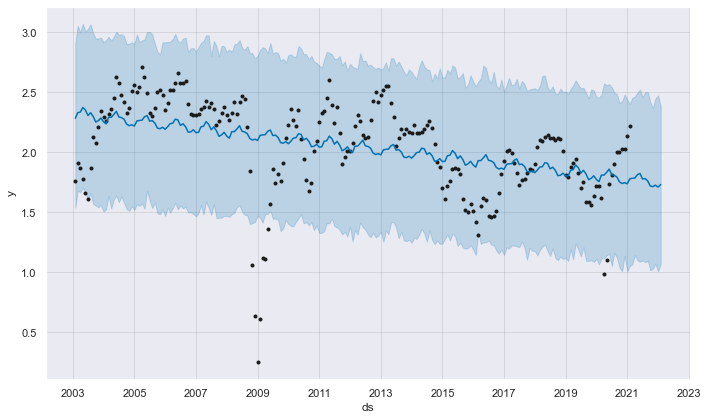

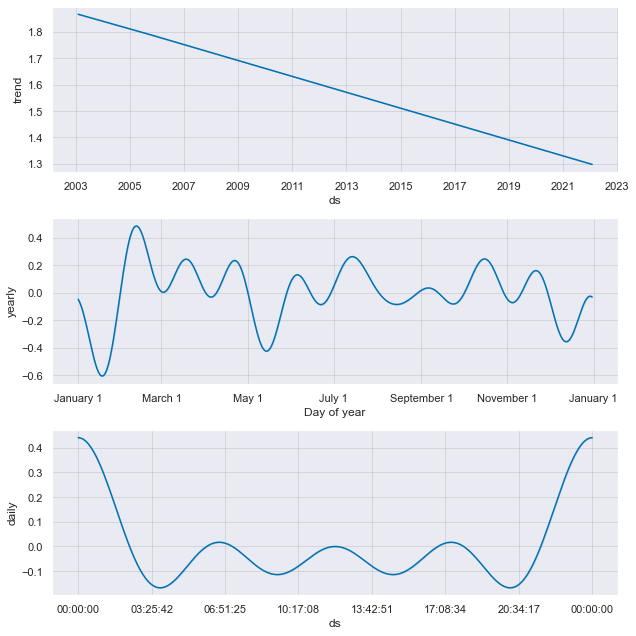

In [8]:
print(model_us_inflation.plot(forecast_us_inflation))
print(model_us_inflation.plot_components(forecast_us_inflation))

In [9]:
## Univariate Model for INR Inflation

inr_inflation_df = inr_inflation_monthly.reset_index()
inr_inflation_df.columns = ['ds','y']
inr_inflation_df['y'] = inr_inflation_df['y'].astype(float)

train_inr_inflation = inr_inflation_df[inr_inflation_df['ds'] < '2021-02-01']
test_inr_inflation = inr_inflation_df[inr_inflation_df['ds'] >= '2021-02-01']

model_inr_inflation = Prophet(interval_width=0.90, daily_seasonality=True) ## 90% confidence interval
model_inr_inflation.fit(train_inr_inflation)
future_inr_inflation = model_inr_inflation.make_future_dataframe(periods=12, freq='M')
forecast_inr_inflation = model_inr_inflation.predict(future_inr_inflation)

result_model_inr_inflation = pd.DataFrame(test_inr_inflation.ds)
result_model_inr_inflation['Actual'] = test_inr_inflation['y']
result_model_inr_inflation['Predicted'] = forecast_inr_inflation['yhat_upper']
print(result_model_inr_inflation)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


            ds      Actual   Predicted
205 2021-02-28  131.110000  133.058053
206 2021-03-31  131.770000  133.304395
207 2021-04-30  137.420000  134.223497
208 2021-05-31  143.802659  134.956760
209 2021-06-30  144.290000  135.731074
210 2021-07-31  144.290000  137.420381
211 2021-08-31  144.290000  137.937783
212 2021-09-30  144.290000  138.621444


Figure(720x432)
Figure(648x648)


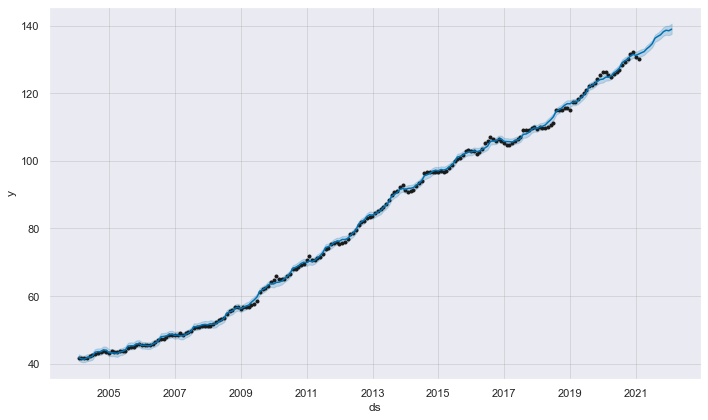

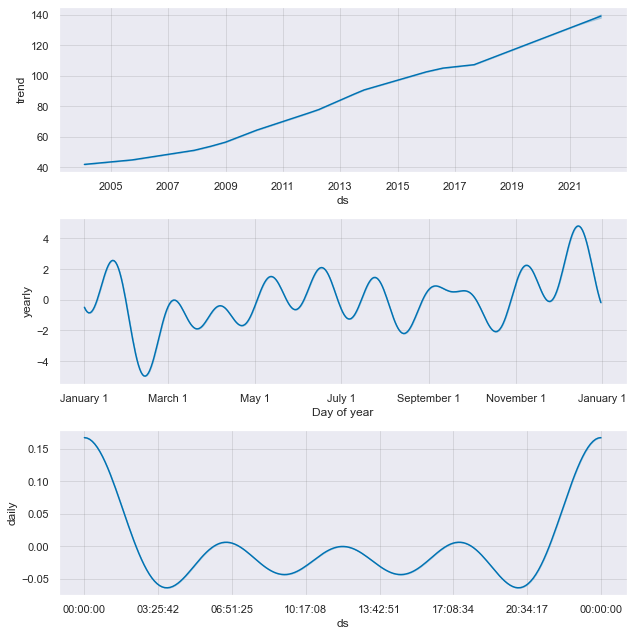

In [10]:
print(model_inr_inflation.plot(forecast_inr_inflation))
print(model_inr_inflation.plot_components(forecast_inr_inflation))

In [17]:
## Univariate Model for UK Inflation

uk_inflation_df = uk_inflation_monthly.reset_index()
uk_inflation_df.columns = ['ds','y']
uk_inflation_df['y'] = uk_inflation_df['y'].astype(float)

train_uk_inflation = uk_inflation_df[uk_inflation_df['ds'] < '2021-02-01']
test_uk_inflation = uk_inflation_df[uk_inflation_df['ds'] >= '2021-02-01']

model_uk_inflation = Prophet(interval_width=0.90, daily_seasonality=True) ## 90% confidence interval
model_uk_inflation.fit(train_uk_inflation)
future_uk_inflation = model_uk_inflation.make_future_dataframe(periods=12, freq='M')
forecast_uk_inflation = model_uk_inflation.predict(future_uk_inflation)

result_model_uk_inflation = pd.DataFrame(test_uk_inflation.ds)
result_model_uk_inflation['Actual'] = test_uk_inflation['y']
result_model_uk_inflation['Predicted'] = forecast_uk_inflation['yhat_upper']
print(result_model_uk_inflation)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


            ds      Actual   Predicted
205 2021-02-28  109.400000  110.367083
206 2021-03-31  109.700000  110.581972
207 2021-04-30  109.846998  110.911753
208 2021-05-31  110.067889  111.156056
209 2021-06-30  110.141585  111.236472
210 2021-07-31  110.141585  111.240883
211 2021-08-31  110.141585  111.591109
212 2021-09-30  110.141585  111.816161


Figure(720x432)
Figure(648x648)


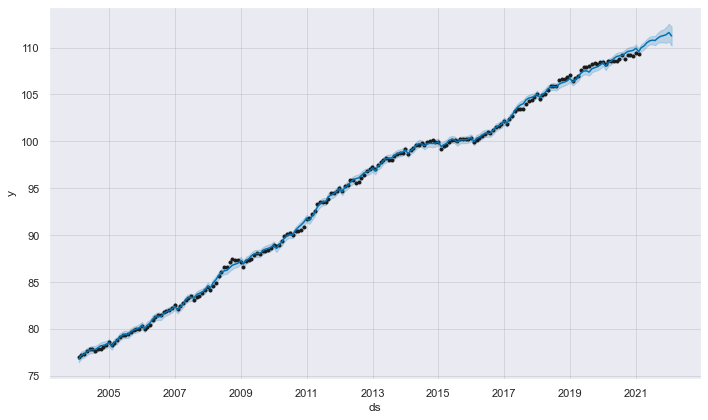

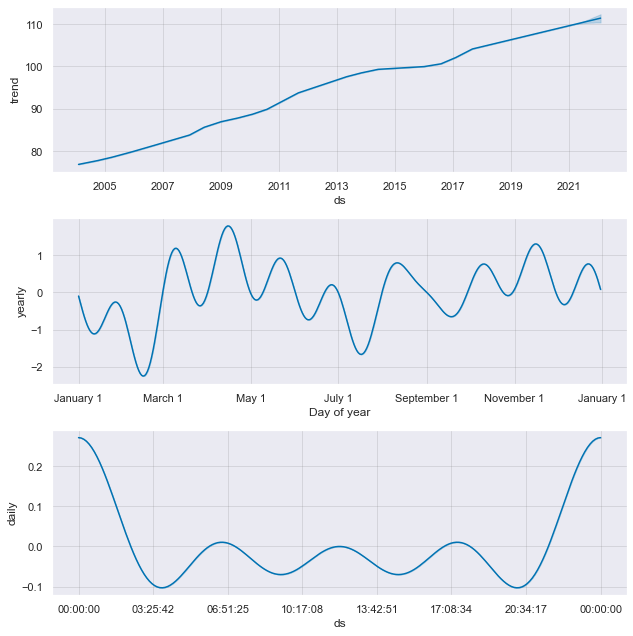

In [18]:
print(model_uk_inflation.plot(forecast_uk_inflation))
print(model_uk_inflation.plot_components(forecast_uk_inflation))

In [15]:
## Univariate Model for Canada Inflation

can_inflation_df = can_inflation_monthly.reset_index()
can_inflation_df.columns = ['ds','y']
can_inflation_df['y'] = can_inflation_df['y'].astype(float)

train_can_inflation = can_inflation_df[can_inflation_df['ds'] < '2021-02-01']
test_can_inflation = can_inflation_df[can_inflation_df['ds'] >= '2021-02-01']

model_can_inflation = Prophet(interval_width=0.90, daily_seasonality=True) ## 90% confidence interval
model_can_inflation.fit(train_can_inflation)
future_can_inflation = model_can_inflation.make_future_dataframe(periods=12, freq='M')
forecast_can_inflation = model_can_inflation.predict(future_can_inflation)

result_model_can_inflation = pd.DataFrame(test_can_inflation.ds)
result_model_can_inflation['Actual'] = test_can_inflation['y']
result_model_can_inflation['Predicted'] = forecast_can_inflation['yhat_upper']
print(result_model_can_inflation)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


            ds    Actual  Predicted
205 2021-02-28  0.011000   0.027000
206 2021-03-31  0.022000   0.025953
207 2021-04-30  0.034000   0.025763
208 2021-05-31  0.026819   0.026255
209 2021-06-30  0.027239   0.026801
210 2021-07-31  0.027276   0.027660
211 2021-08-31  0.028089   0.026612
212 2021-09-30  0.027752   0.025858


Figure(720x432)
Figure(648x648)


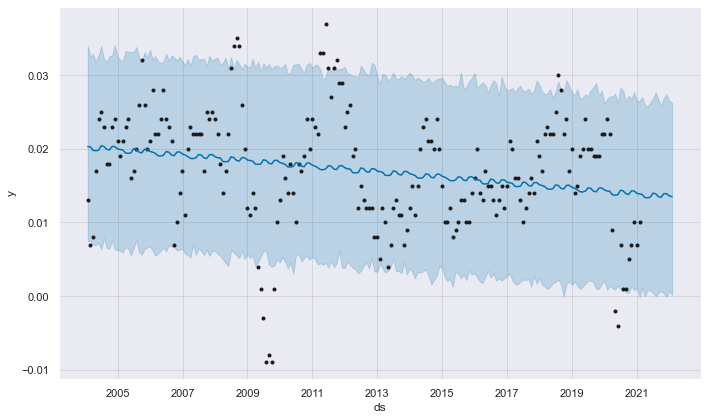

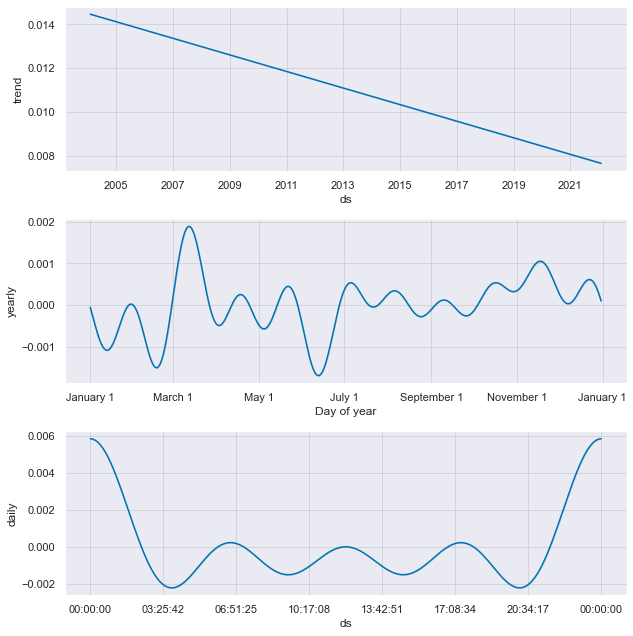

In [16]:
print(model_can_inflation.plot(forecast_can_inflation))
print(model_can_inflation.plot_components(forecast_can_inflation))